In [1]:
import sys

sys.path.append("..")

%load_ext autoreload
%autoreload complete

In [2]:
from pathlib import Path
import pickle
import json

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr

from lmrecon.plotting import format_plot, get_field_label, get_field_unit, plot_field, subplots_cartopy, add_subplot_headers
from lmrecon.plotting_config import set_plotting_theme
from lmrecon.stats import (
    area_weighted_mean,
    rmse,
    mse,
    average_seasonally,
    average_annually,
    anomalize,
    localize_gc5thorder,
    compute_field_stds,
    compute_field_stds_by_season,
    area_weighted_rmse,
    annualize_seasonal_data,
    compute_field_stds,
    anomalize,
)
from lmrecon.util import get_base_path
from lmrecon.datasets import *

set_plotting_theme()

In [3]:
ds_hadcrut = load_hadcrut()
ds_hadisst = load_hadisst()
ds_ersst = load_ersst()
ds_cobesst = load_cobesst()
ds_gistemp = load_gistemp()
ds_cooper25 = load_cooper25()
ds_sic = load_cdr_sic()
ds_eruptions = load_combined_eruptions()

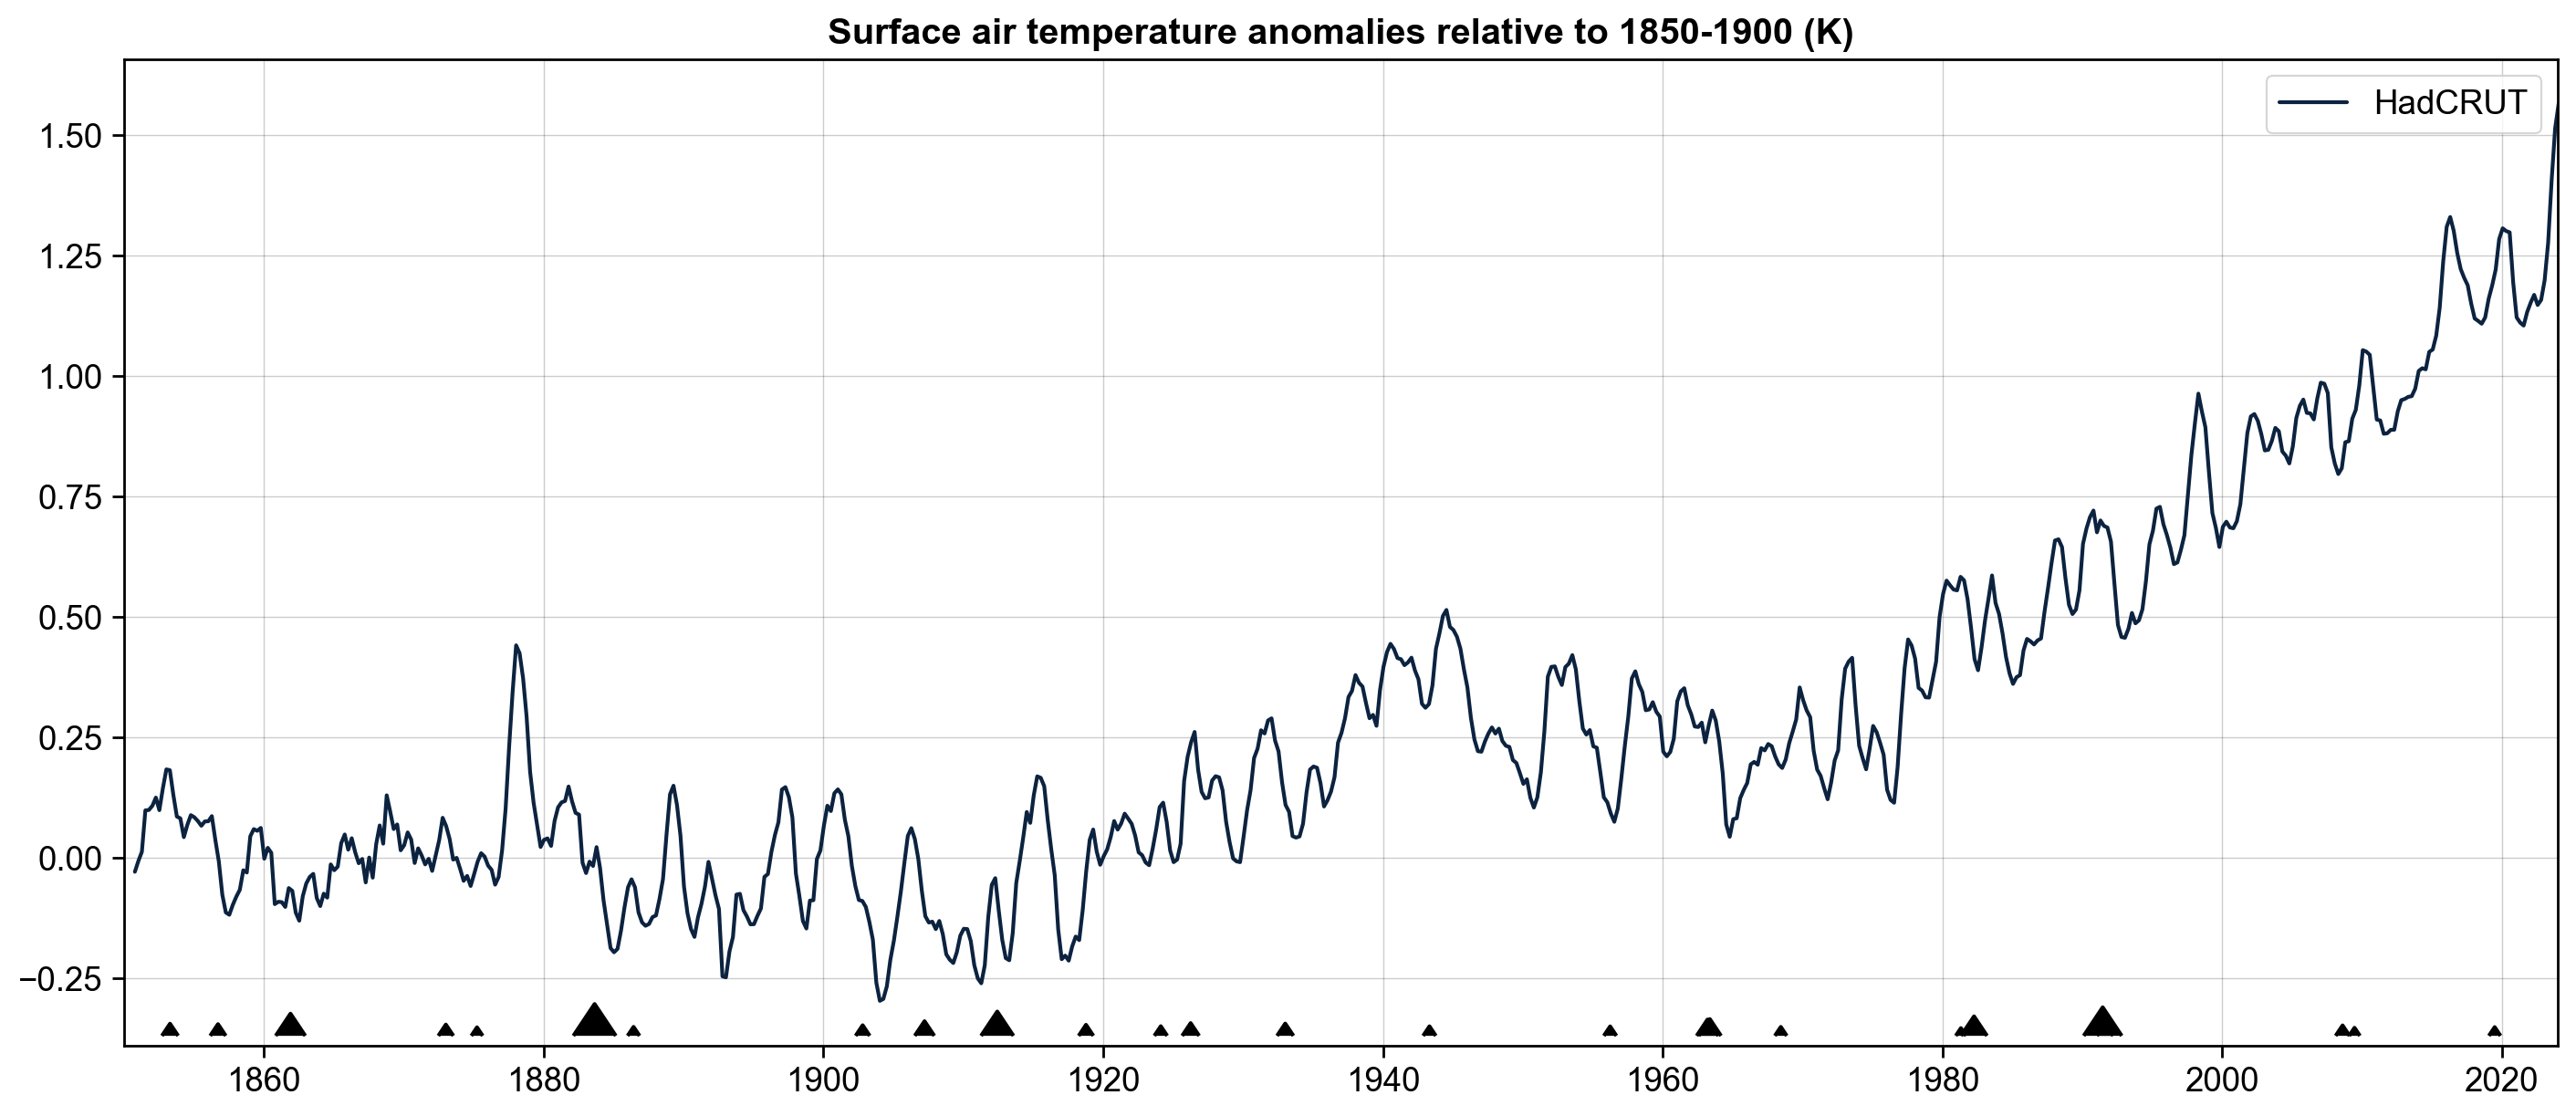

In [14]:
def plot_tas():
    fig, ax = plt.subplots()

    hadcrut = area_weighted_mean(ds_hadcrut["tas"]).rolling(time=4, center=True).mean()
    # hadcrut = average_annually(area_weighted_mean(ds_hadcrut["tas"]))
    # gistemp = average_annually(area_weighted_mean(ds_gistemp["tas"]))
    cooper = average_annually(area_weighted_mean(ds_cooper25["tas"]))

    hadcrut = anomalize(hadcrut, (1850, 1900))
    cooper = anomalize(cooper, (1850, 1900))

    ax.plot(hadcrut.time, hadcrut, label="HadCRUT")
    # ax.plot(gistemp.time, gistemp, label="GISTEMP")
    # ax.plot(cooper.time, cooper, label="Cooper et al. (2025)")

    trans = mpl.transforms.blended_transform_factory(
        ax.transData, ax.transAxes)
    ax.scatter(ds_eruptions.time, 0.01 * np.ones(len(ds_eruptions.time)), transform=trans,
                s=ds_eruptions.vssi*30, c="black", marker=mpl.markers.CARETUPBASE)

    ax.legend()
    ax.set_xlim(1850, 2024)
    ax.set_title(f"{get_field_label('tas')} anomalies relative to 1850-1900 (K)")

    format_plot(major_grid=True)

plot_tas()

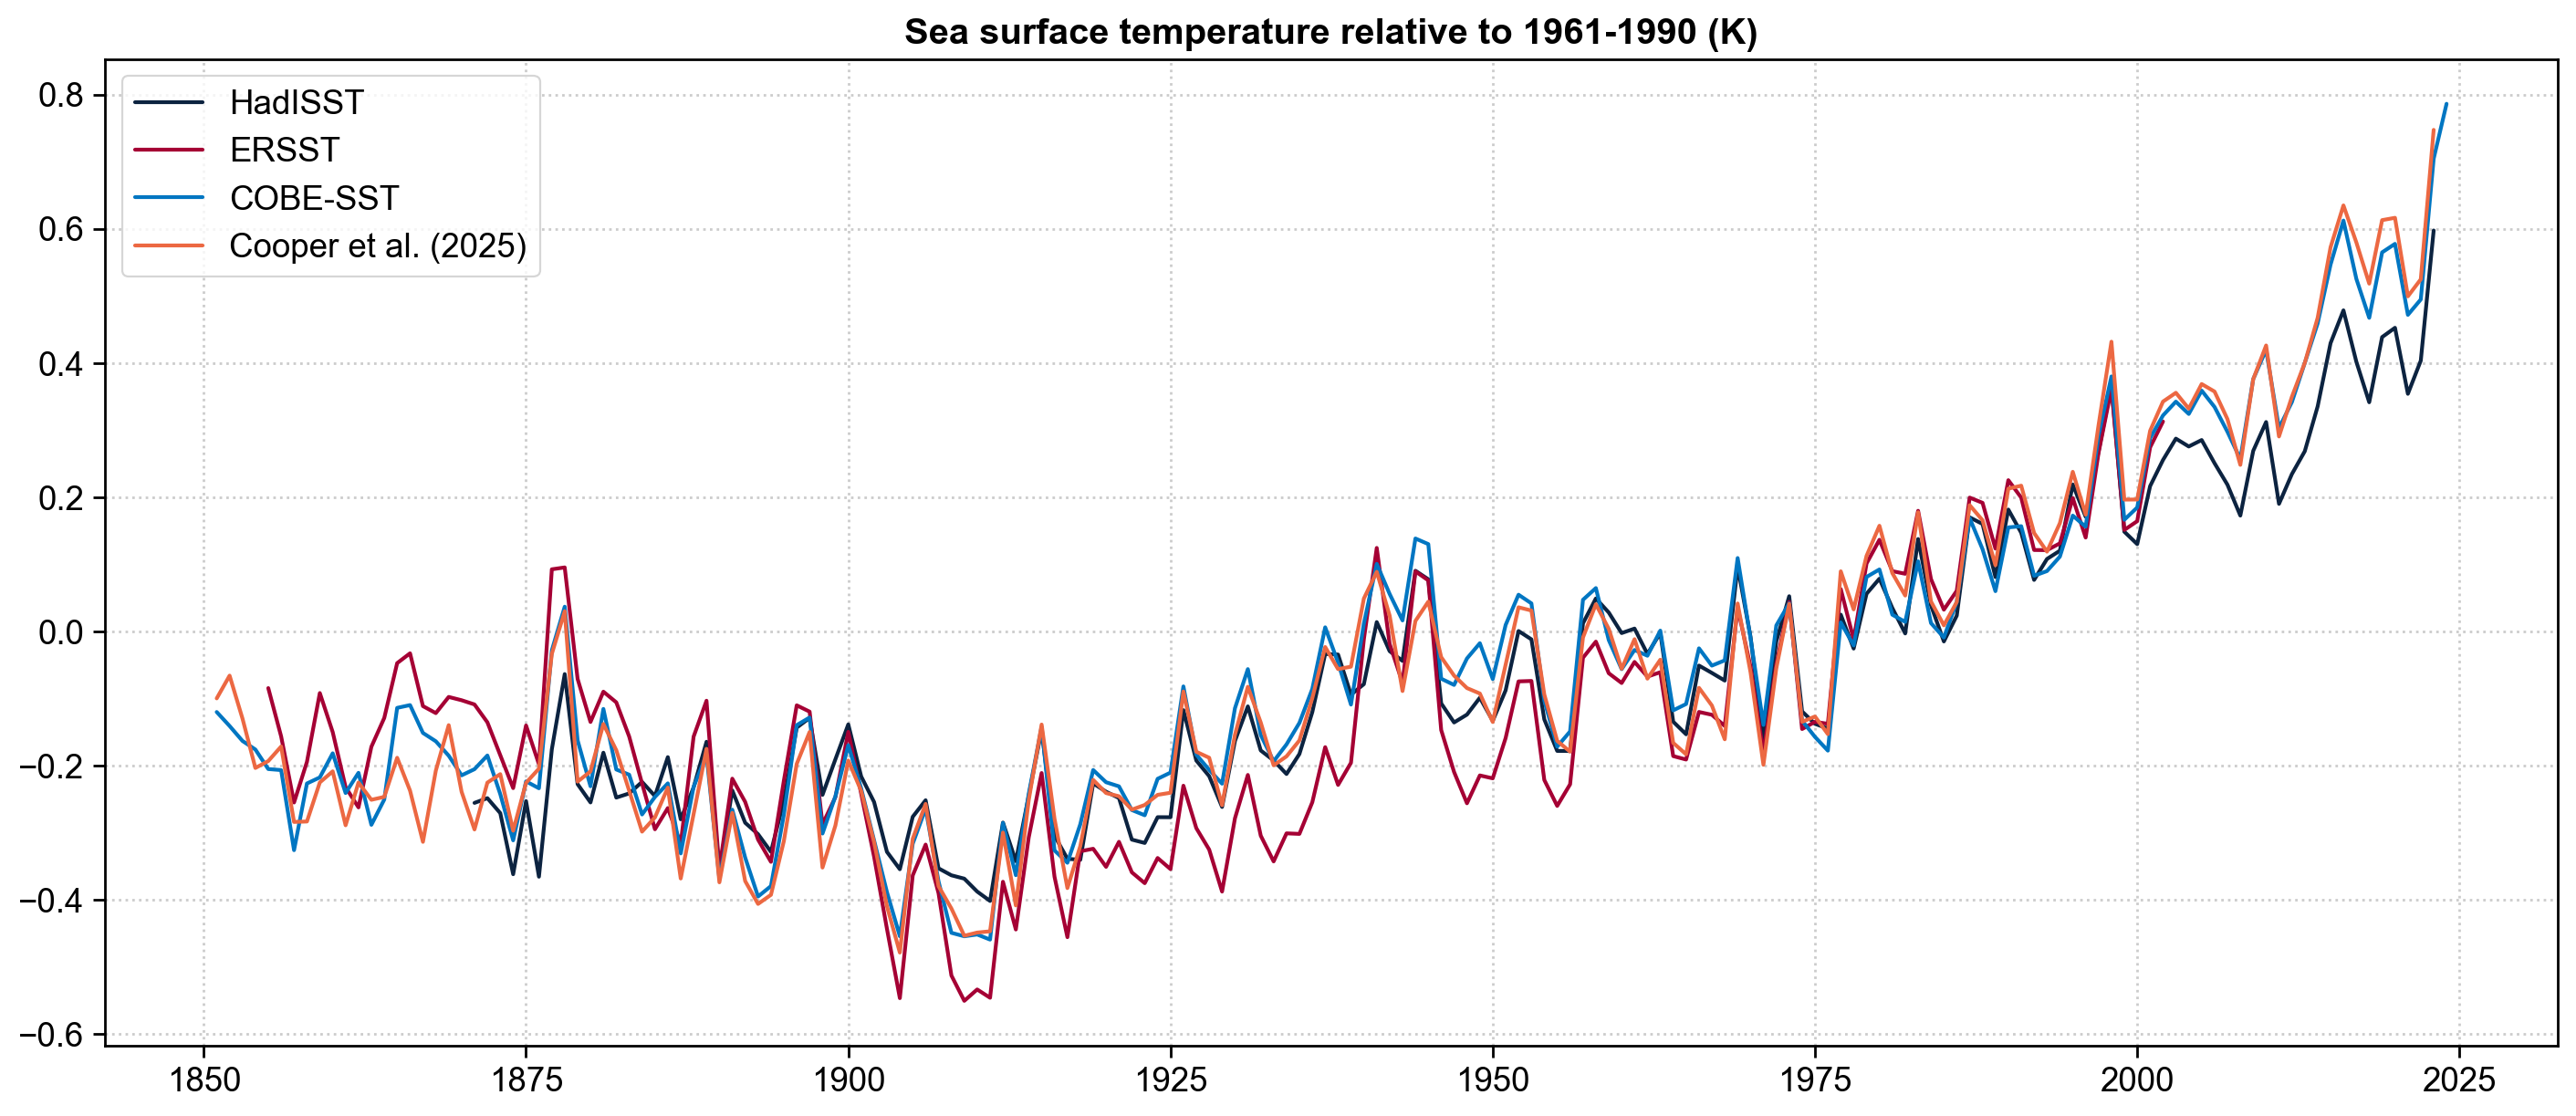

In [ ]:
def plot_tos():
    fig, ax = plt.subplots()

    hadisst = average_annually(area_weighted_mean(ds_hadisst["tos"]))
    ersst = average_annually(area_weighted_mean(ds_ersst["tos"]))
    cobesst = average_annually(area_weighted_mean(ds_cobesst["tos"]))
    cooper = average_annually(area_weighted_mean(ds_cooper25["tos"]))

    ax.plot(hadisst.time, hadisst, label="HadISST")
    ax.plot(ersst.time, ersst, label="ERSST")
    ax.plot(cobesst.time, cobesst, label="COBE-SST")
    ax.plot(cooper.time, cooper, label="Cooper et al. (2025)")
    ax.legend()
    # ax.set_xlim(1850, 2024)
    ax.set_title(f"{get_field_label('tos')} relative to 1961-1990 (K)")

    format_plot(major_grid=True)

plot_tos()

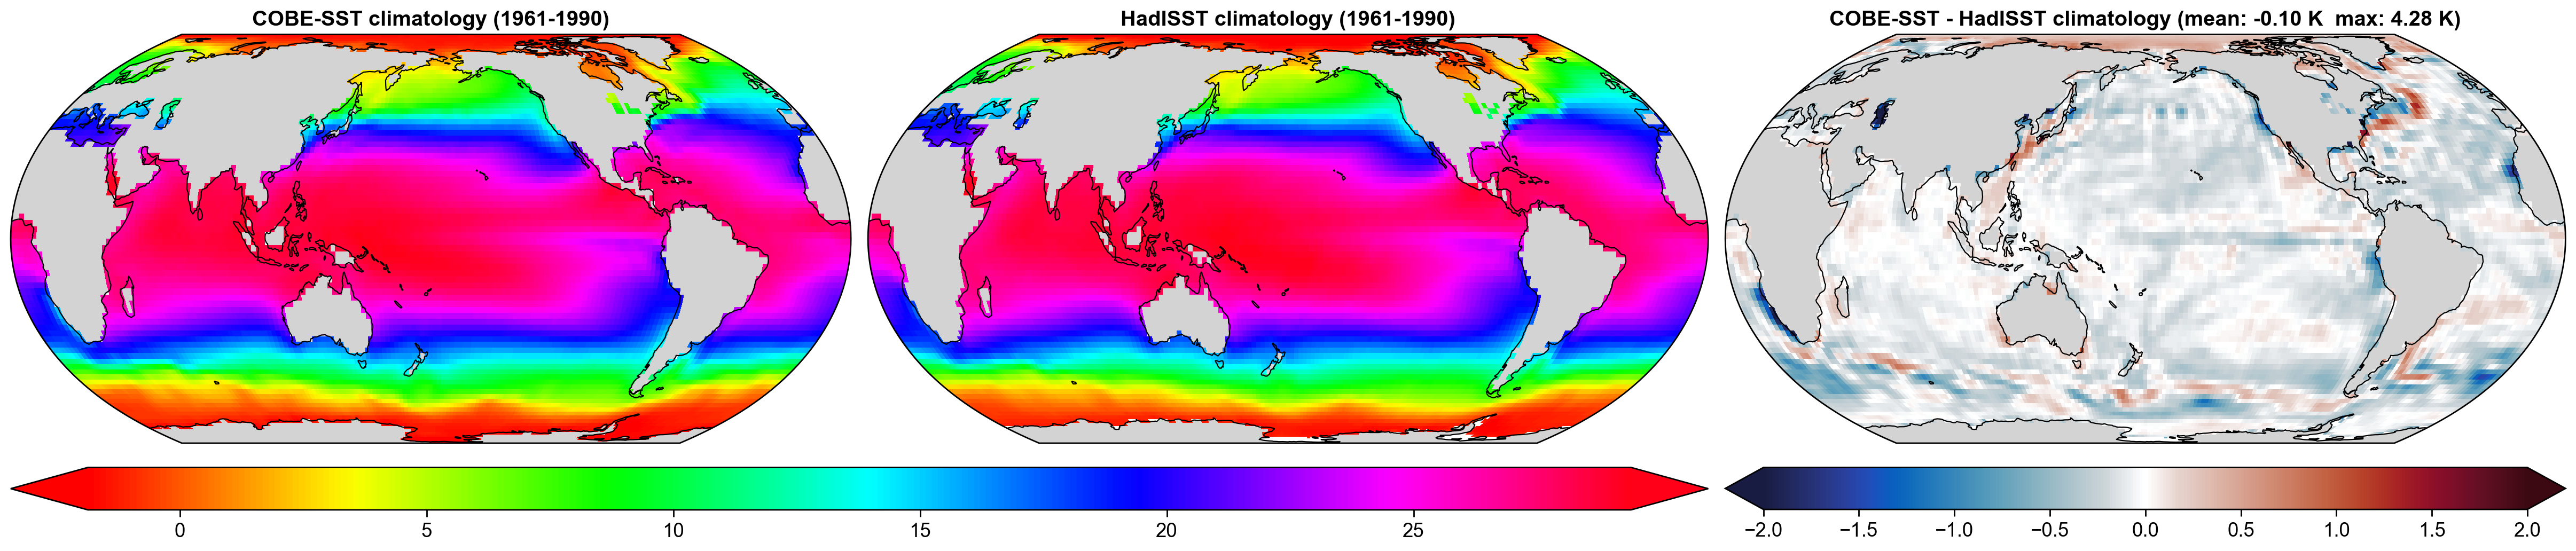

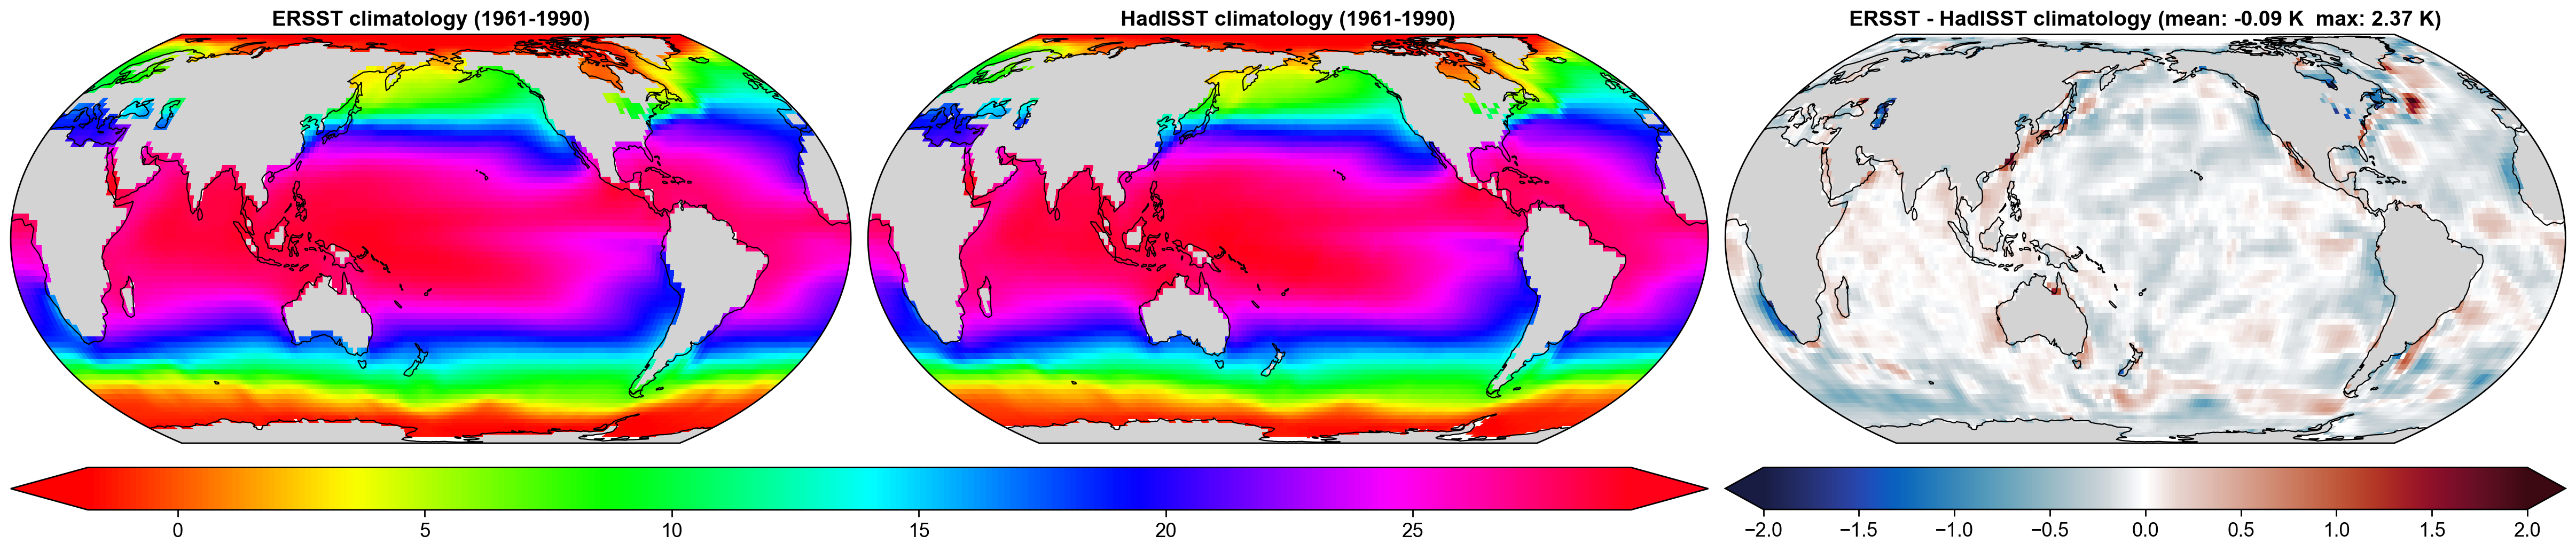

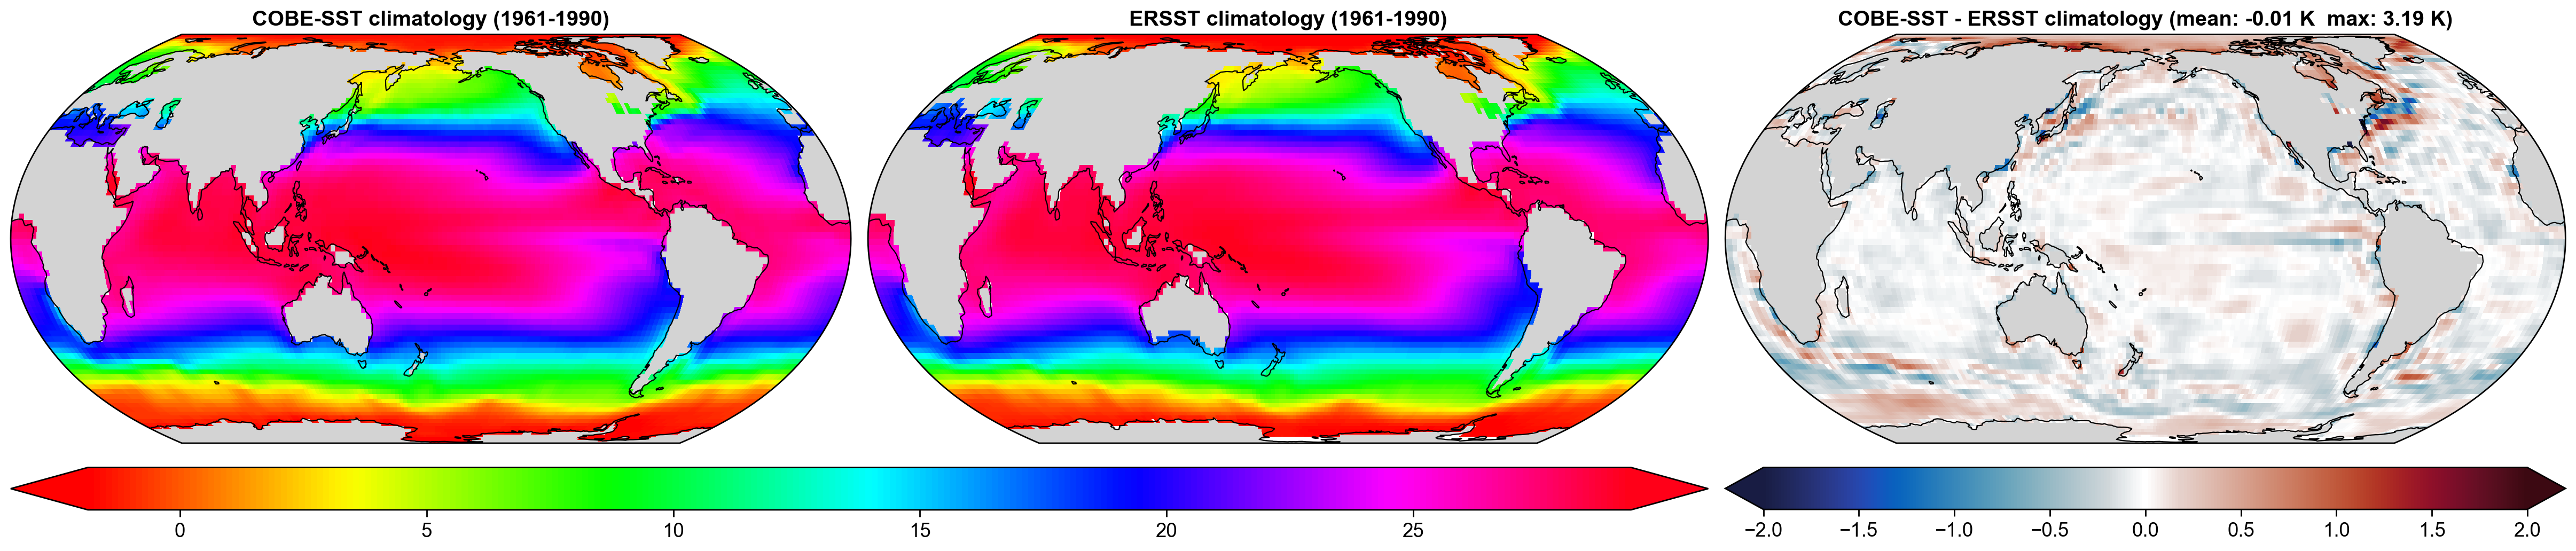

In [105]:
def plot_tos_climatology(load_a, load_b, label_a, label_b):
    fig, axs = subplots_cartopy(1, 3)
    a = load_a(anomalies=False)["tos"].sel(time=slice(1961, 1991)).mean("time")
    b = load_b(anomalies=False)["tos"].sel(time=slice(1961, 1991)).mean("time")
    diff = a - b

    plot_field(axs[:2], [a, b], plot_method="pcolormesh", shade_land=True, same_limits=False, cmap="hsv")
    axs[0].set_title(f"{label_a} climatology (1961-1990)")
    axs[1].set_title(f"{label_b} climatology (1961-1990)")

    ax = axs[2]
    plot_field(ax, diff, plot_method="pcolormesh", shade_land=True,
               vmin=-2, vmax=2)
    ax.set_title(f"{label_a} - {label_b} climatology "
                f"(mean: {area_weighted_mean(diff).item():.2f} K  max: {np.abs(diff).max().item():.2f} K)")

plot_tos_climatology(load_cobesst, load_hadisst, "COBE-SST", "HadISST")
plot_tos_climatology(load_ersst, load_hadisst, "ERSST", "HadISST")
plot_tos_climatology(load_cobesst, load_ersst, "COBE-SST", "ERSST")

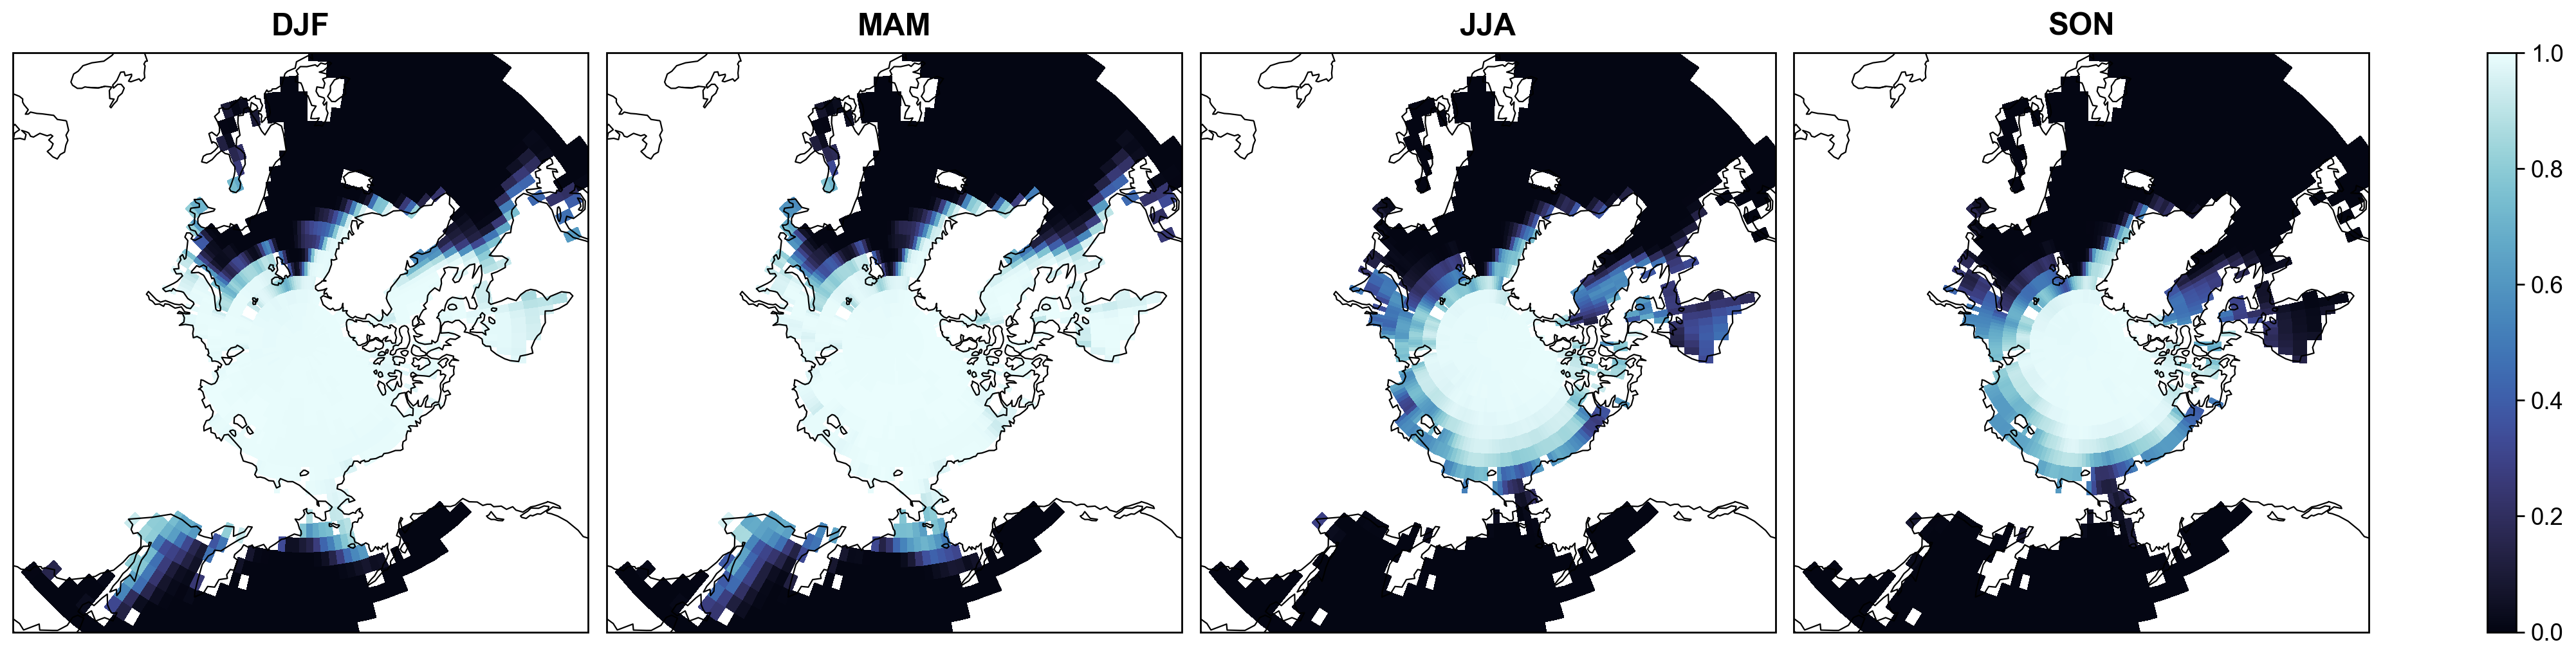

In [7]:
def plot_sic_climatology(projection):
    fig, axs = subplots_cartopy(1, 4, projection=projection)

    ds = xr.open_dataset(get_base_path() / "datasets/seaice/nsidc_sic_cdr/climatology_1979-2000.nc")["siconc"]
    plot_field(axs, [ds.isel(season=i) for i in range(4)], cmap="cmo.ice", vmin=0, vmax=1, extend="neither",
               plot_method="pcolormesh", cbar_orientation="vertical")
    add_subplot_headers(None, ds.season.values)

plot_sic_climatology("arctic")

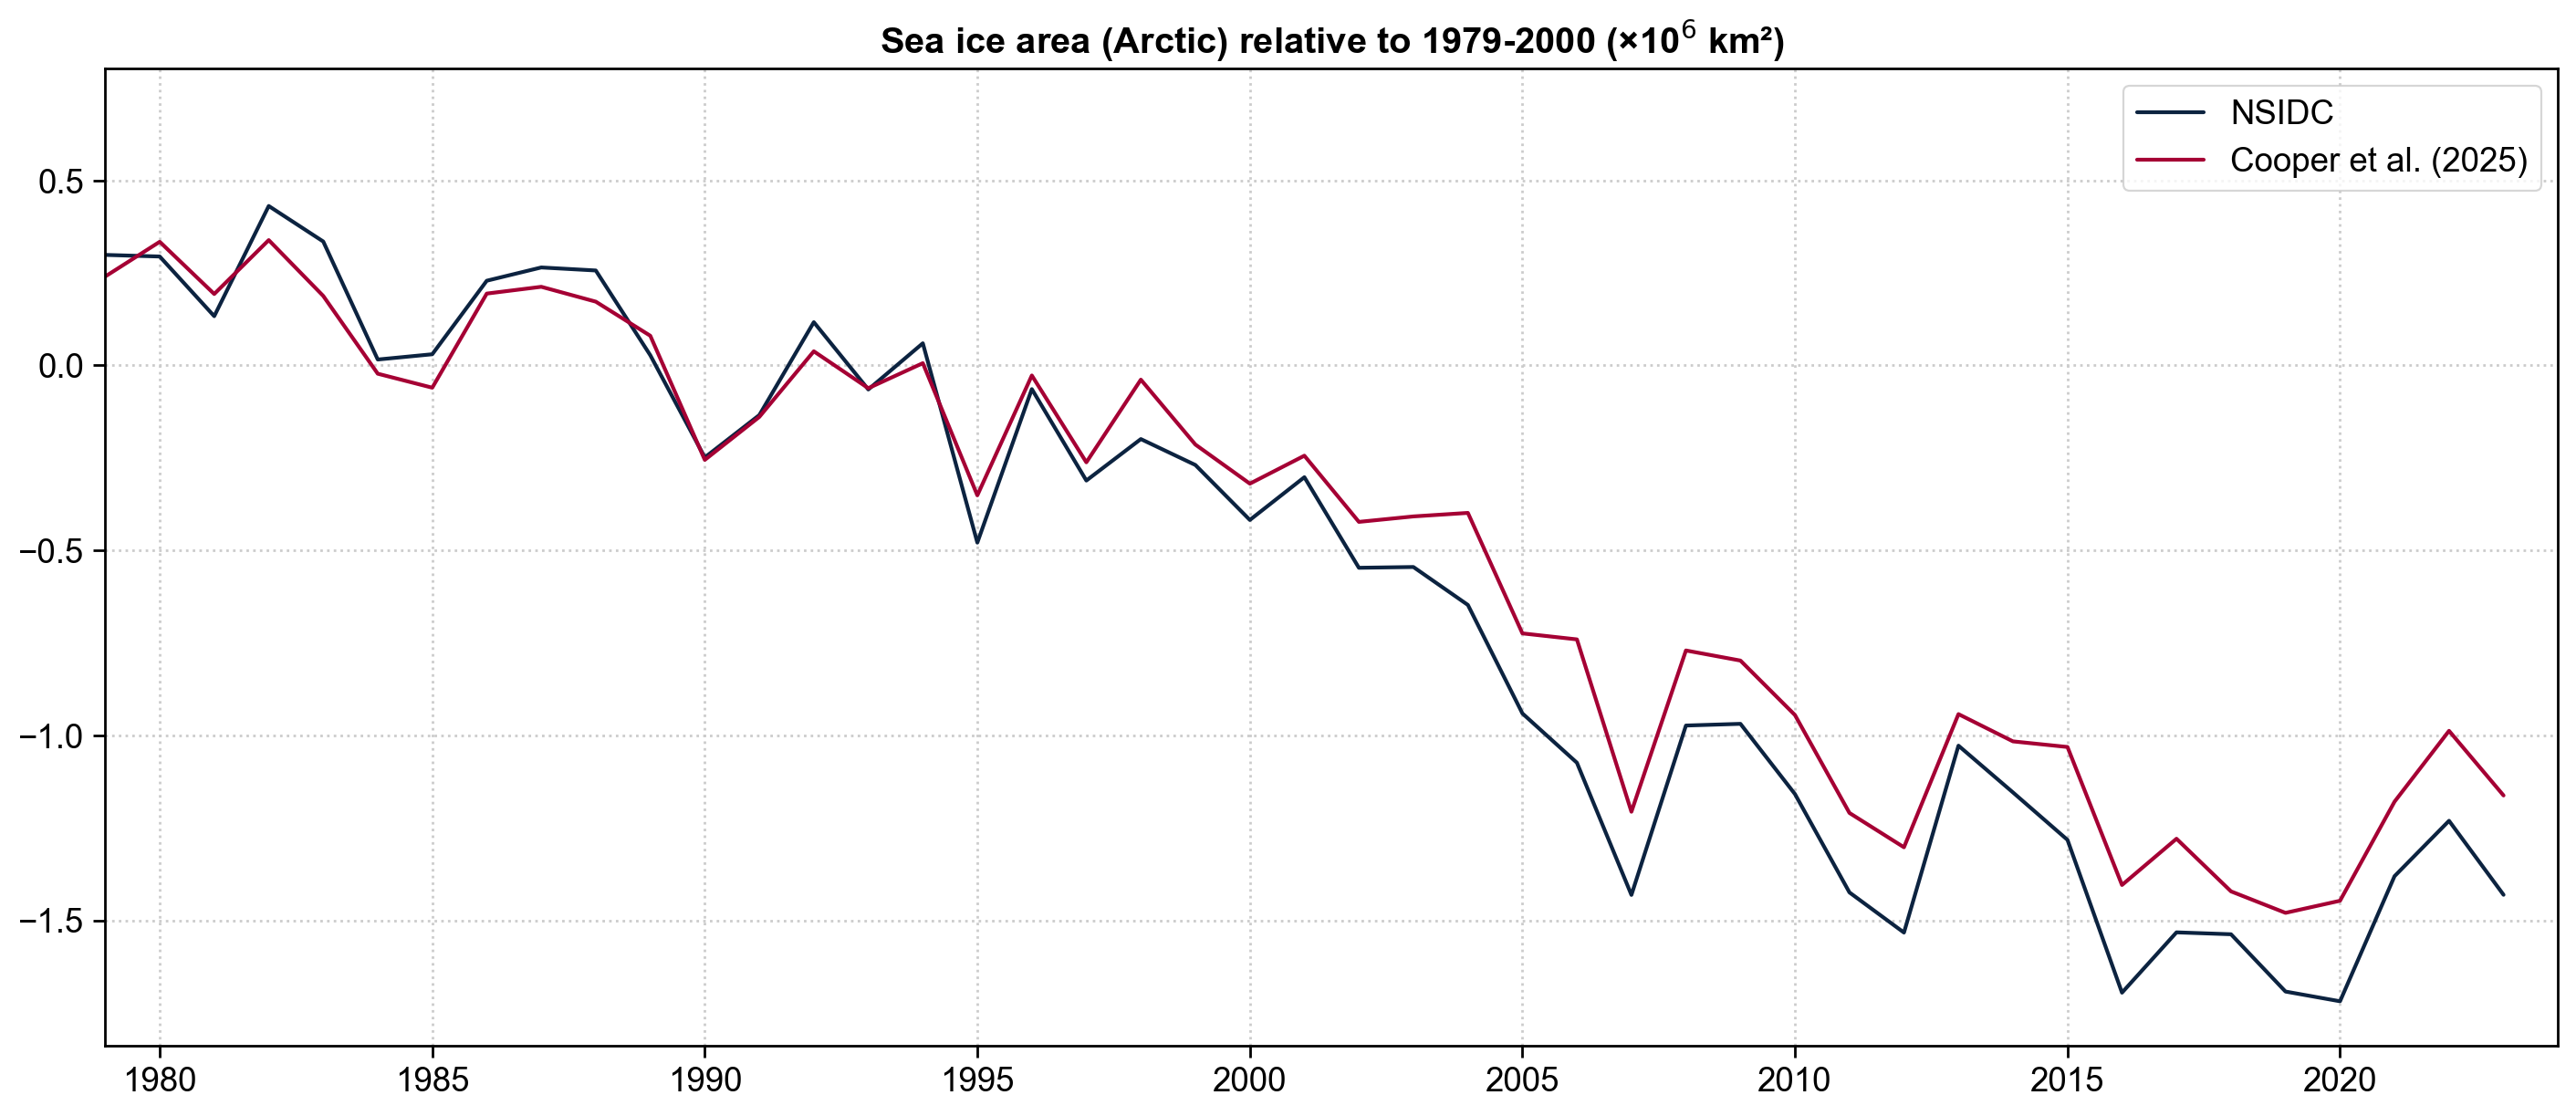

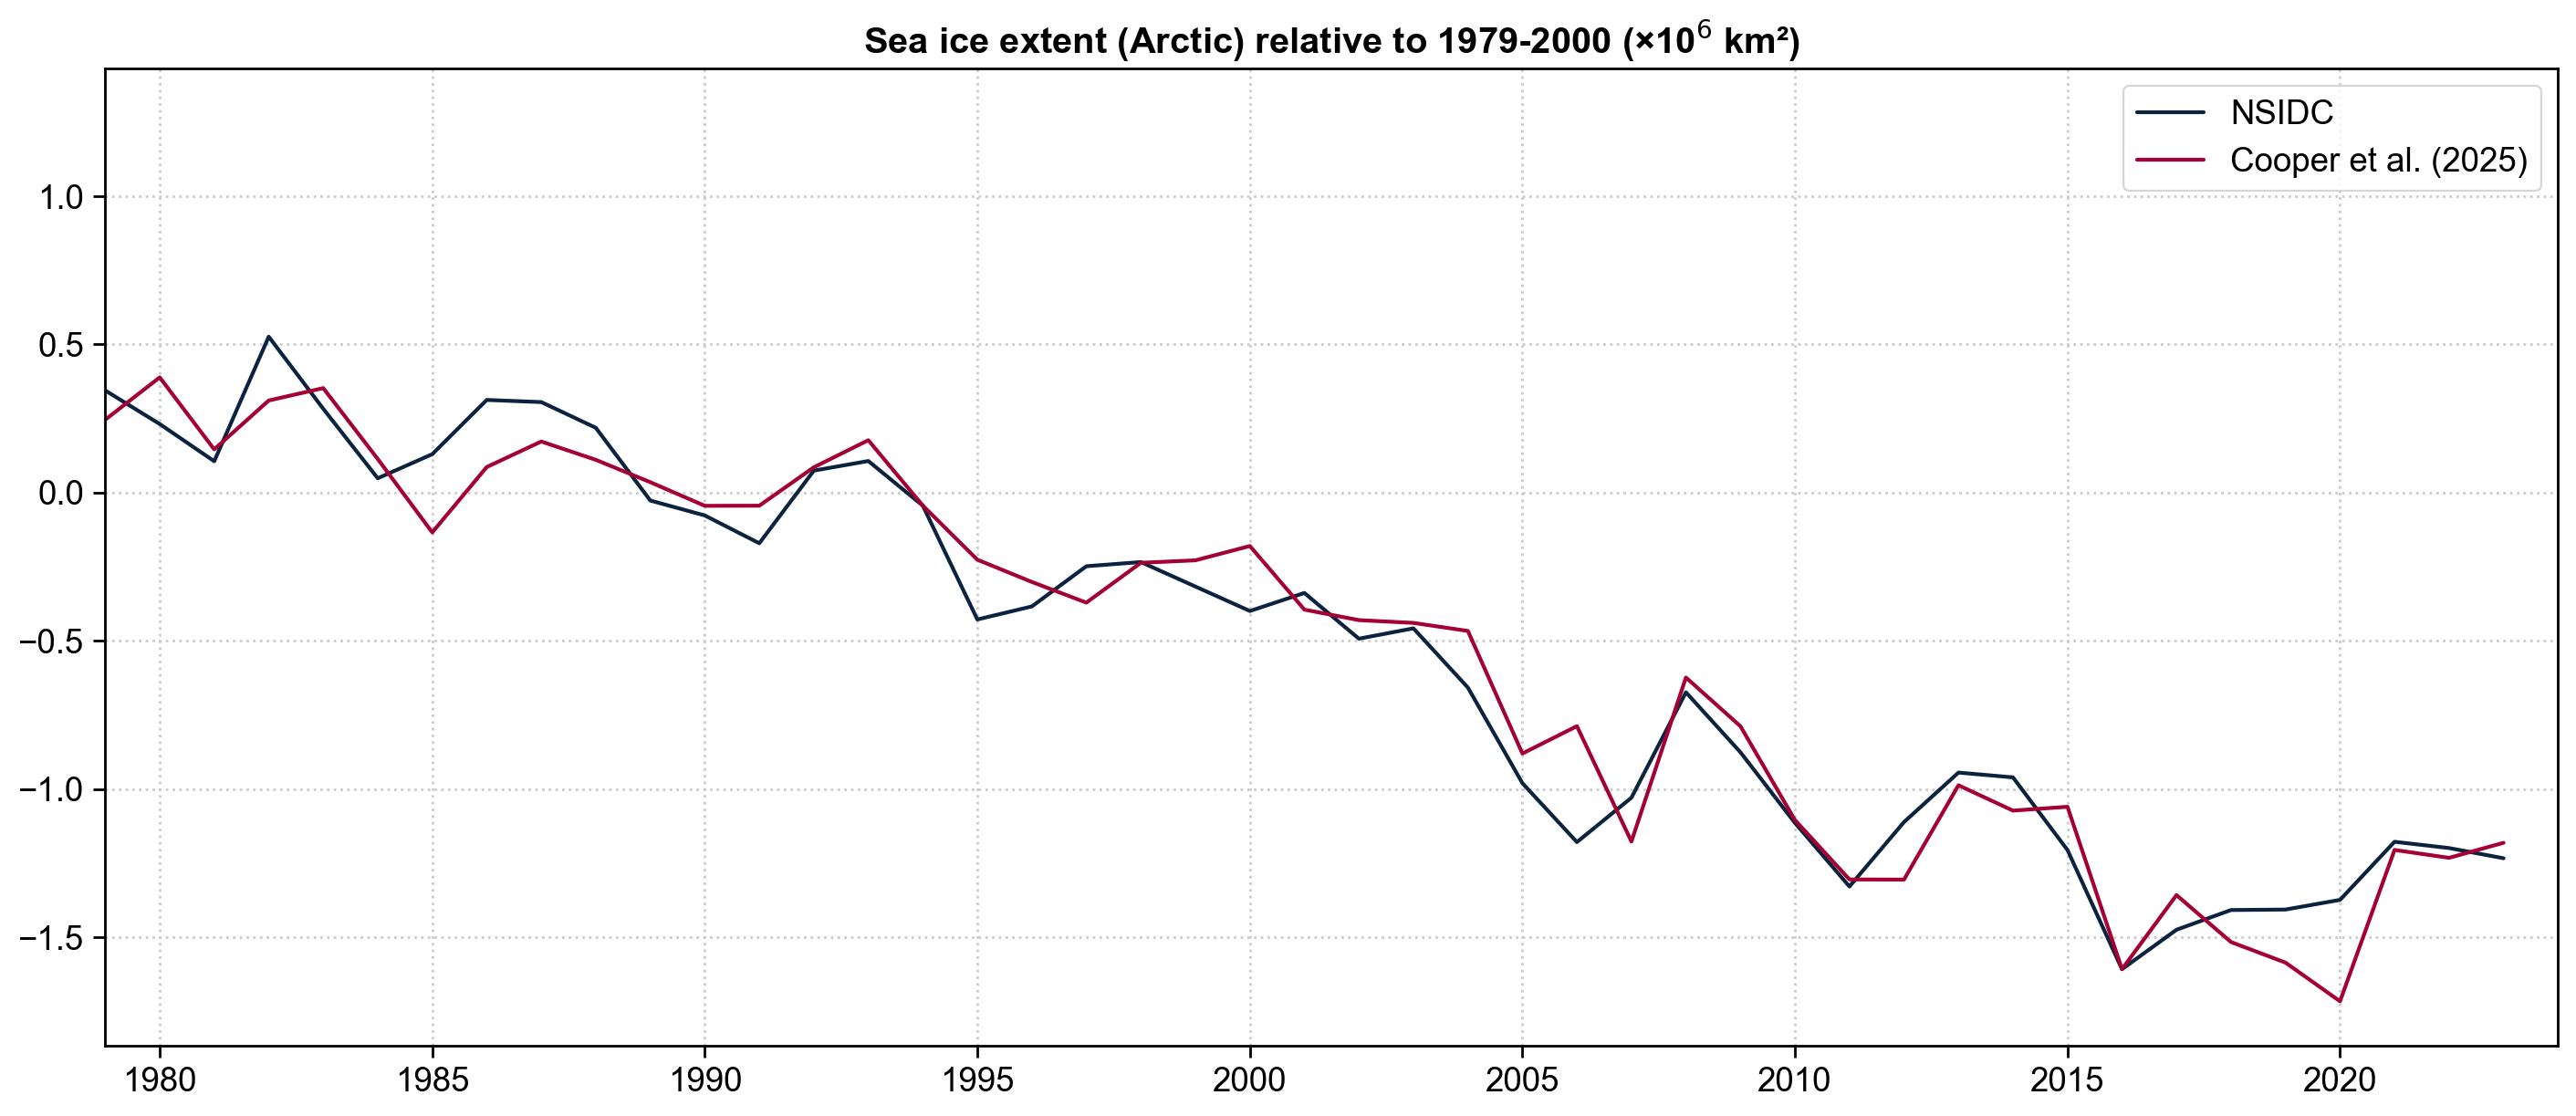

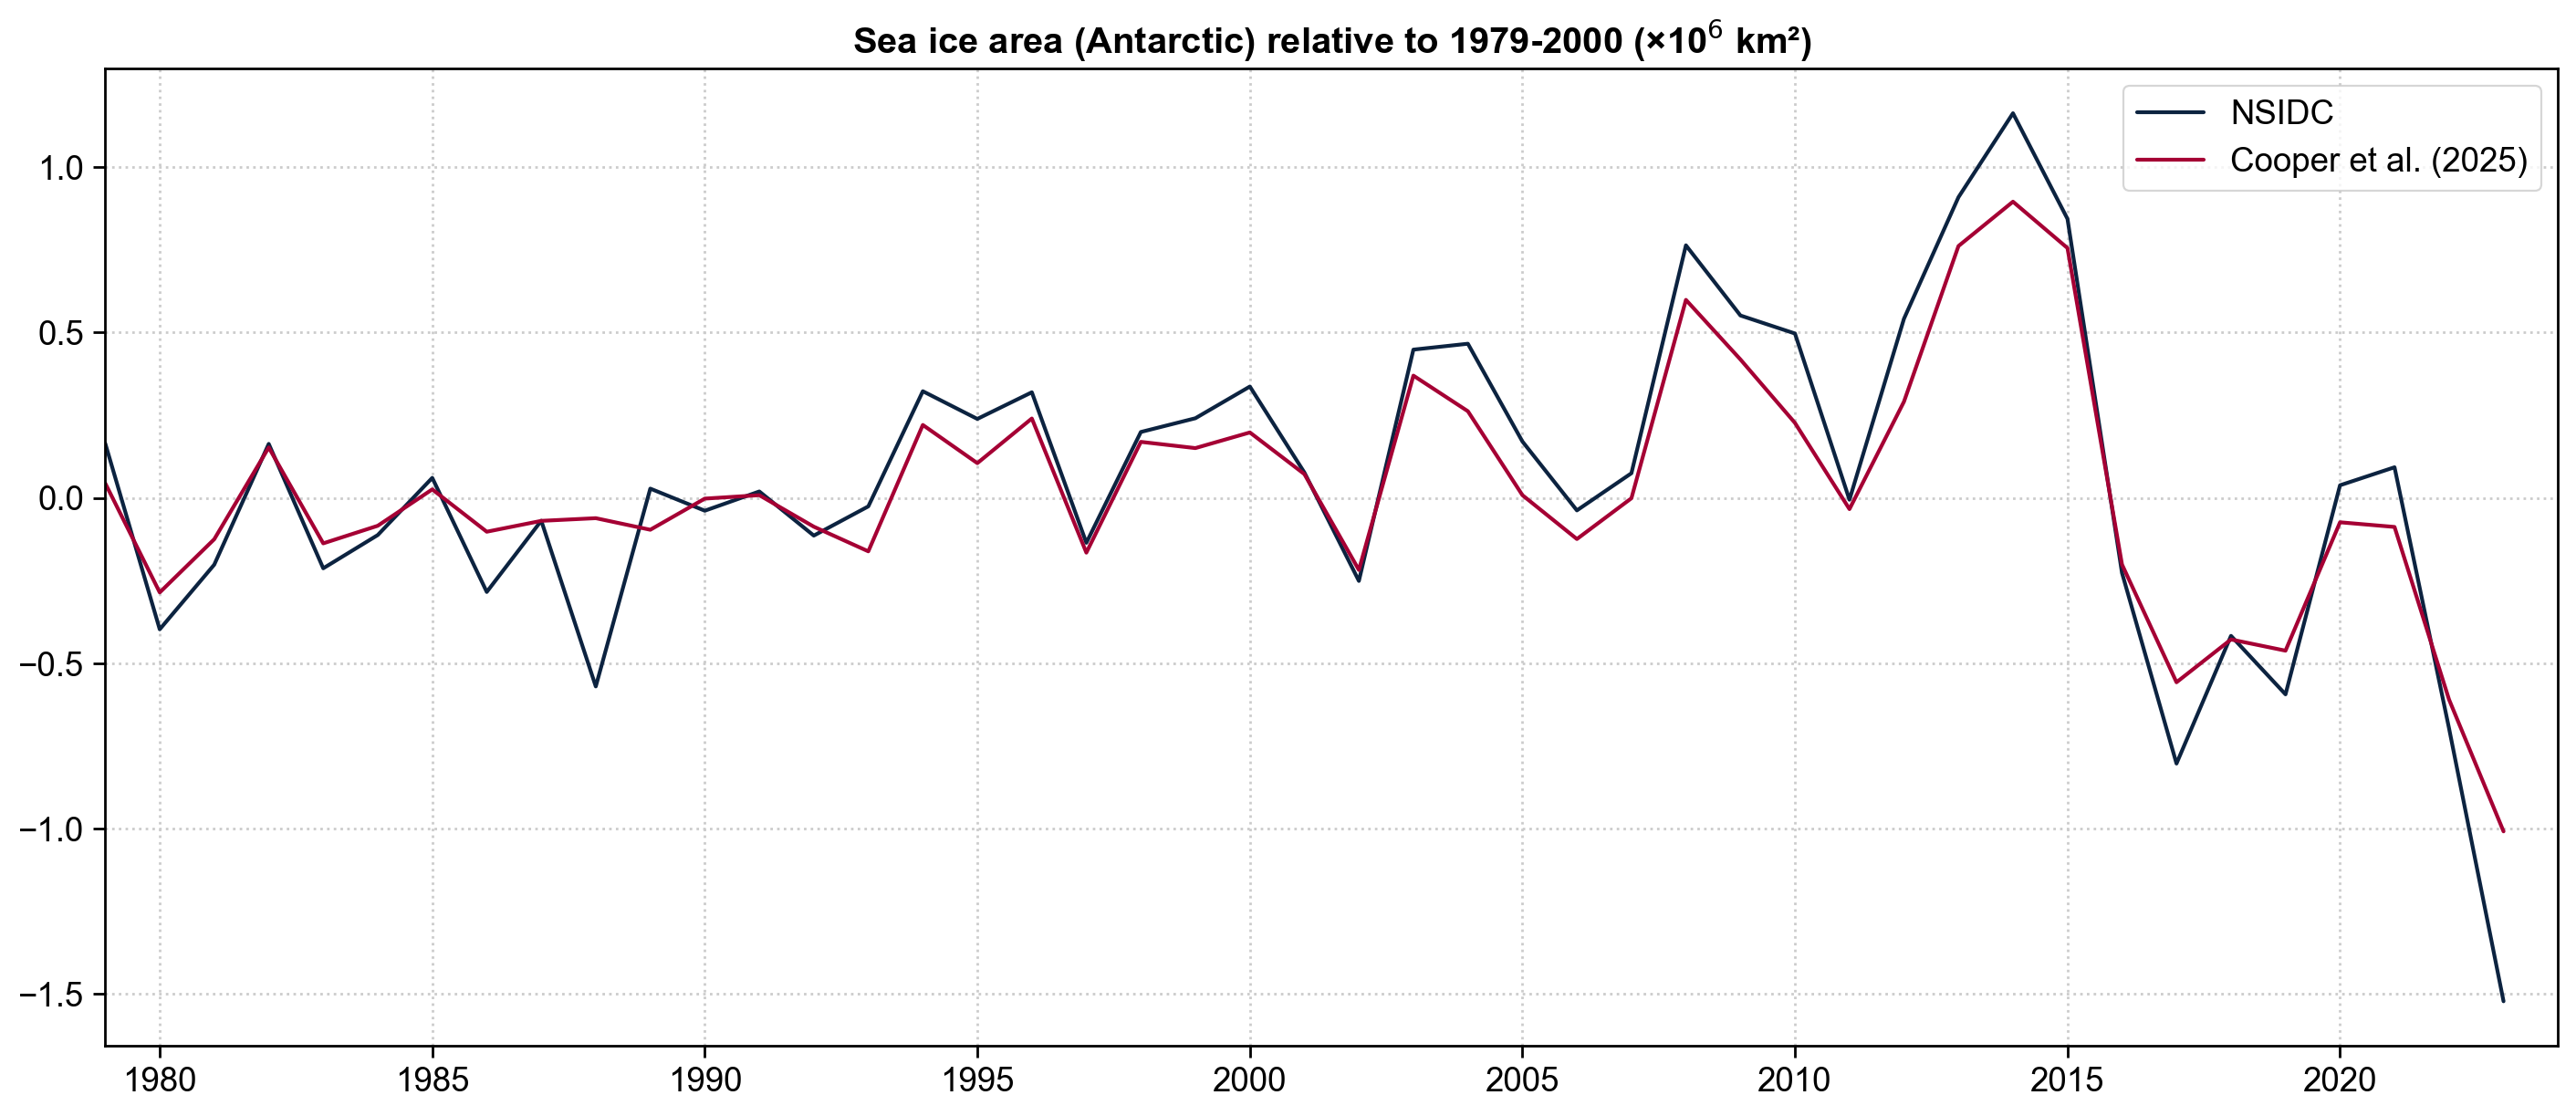

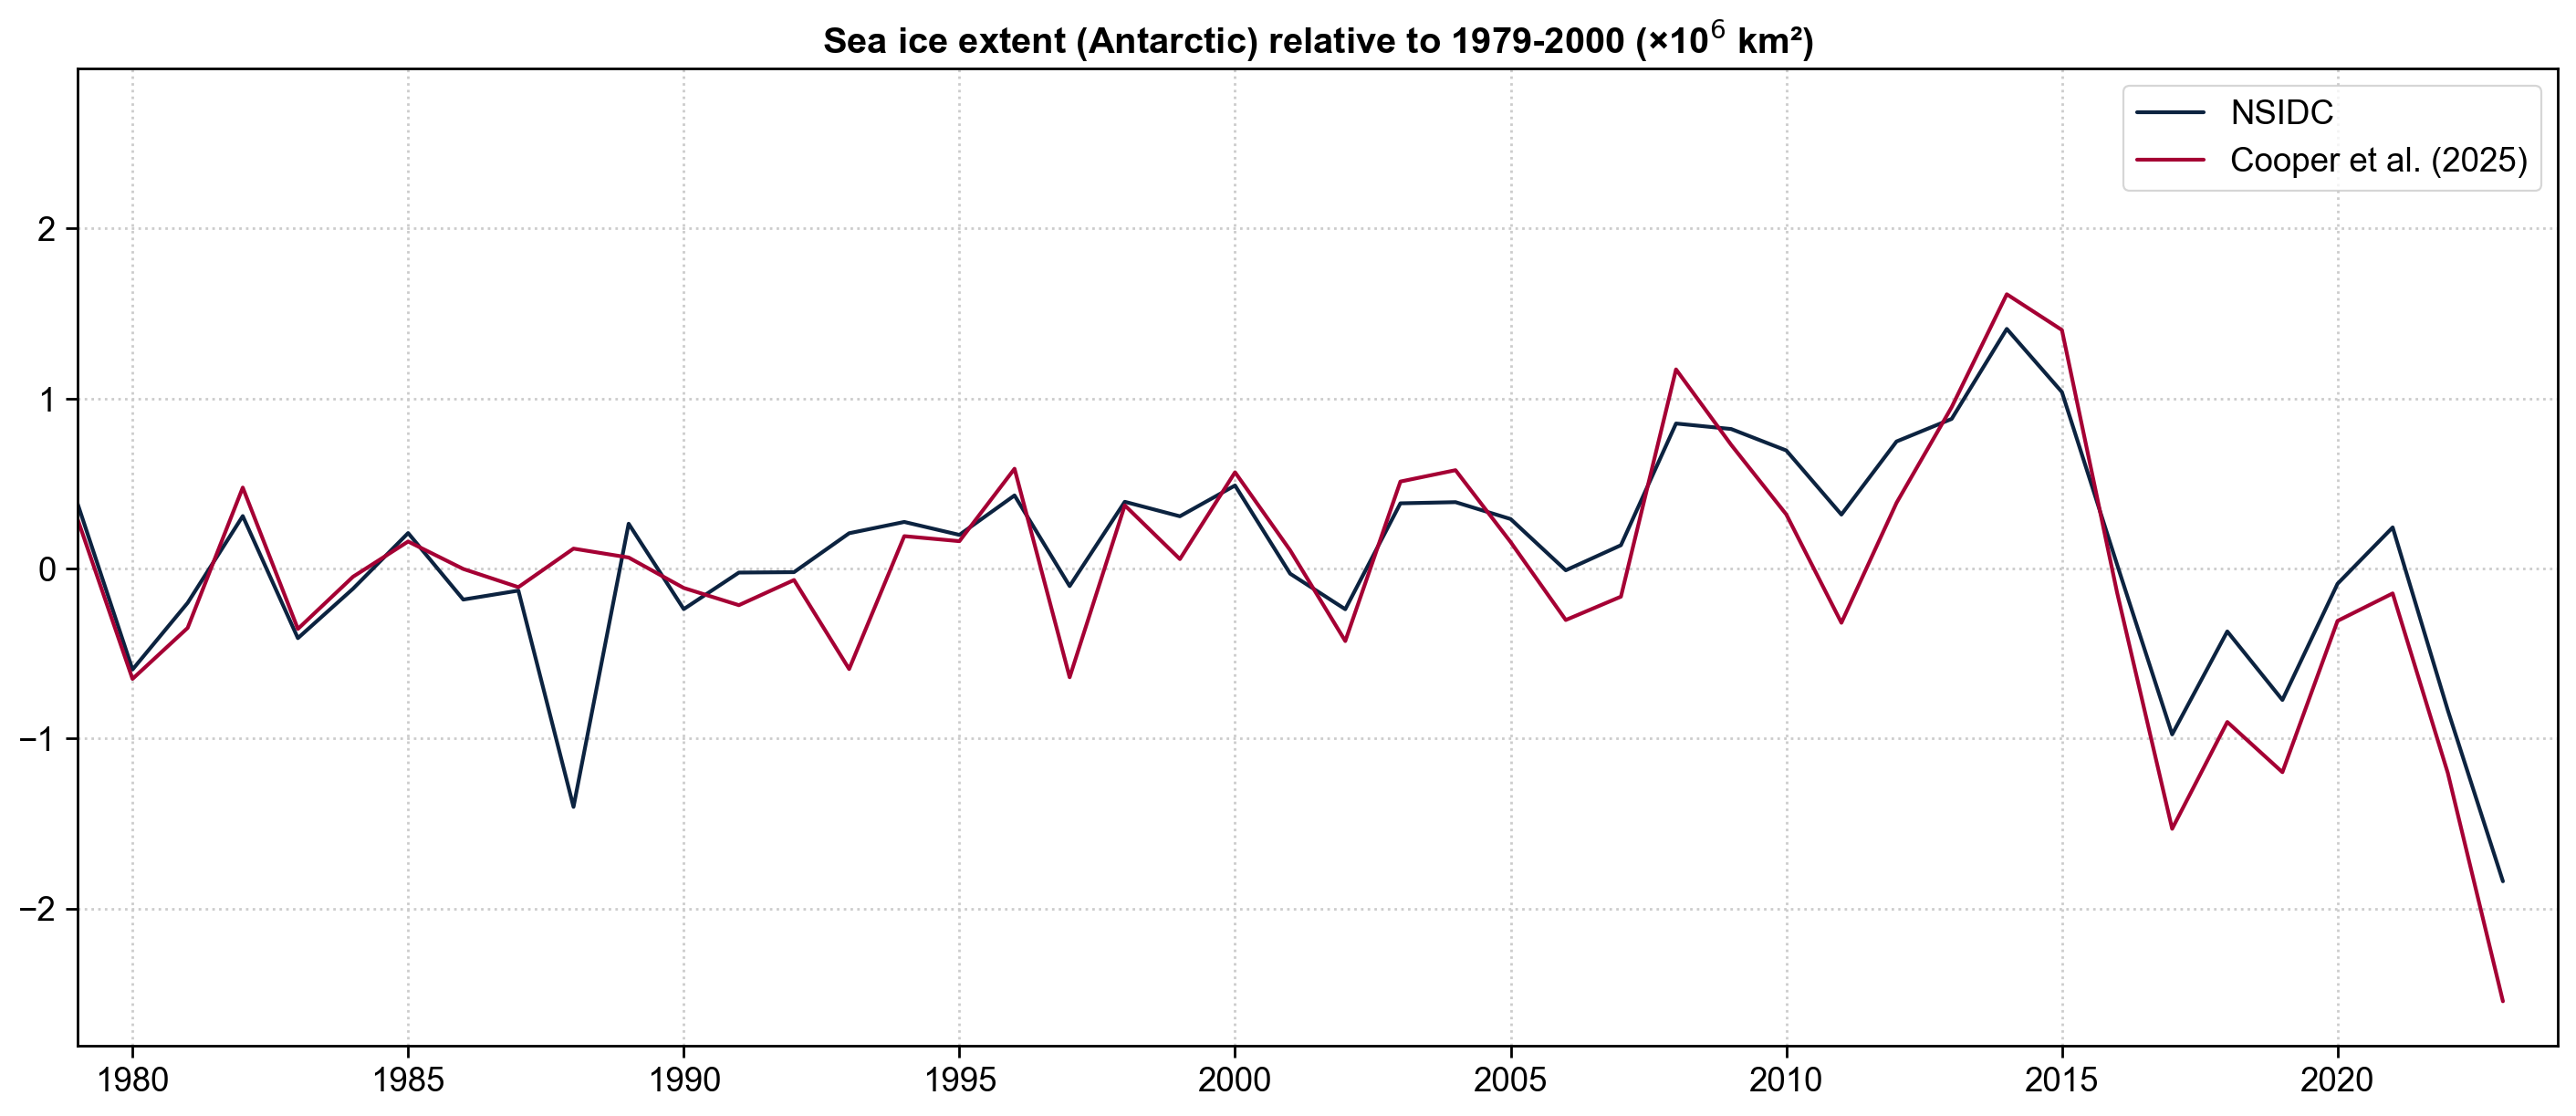

In [23]:
def plot_siarea(field):
    fig, ax = plt.subplots()

    sic = anomalize(average_annually(ds_sic[field]), (1979, 2001)) / 1e6
    cooper = anomalize(average_annually(ds_cooper25[field]), (1979, 2001)) / 1e6

    ax.plot(sic.time, sic, label="NSIDC")
    ax.plot(cooper.time, cooper, label="Cooper et al. (2025)")
    ax.legend()
    ax.set_xlim(1979, 2024)
    ax.set_title(f"{get_field_label(field)} relative to 1979-2000 (×10$^6$ km²)")

    format_plot(major_grid=True)

plot_siarea("siarean")
plot_siarea("siextentn")
plot_siarea("siareas")
plot_siarea("siextents")